# Gradient Conflict Visualization (JSONL logs)

This notebook visualizes JSONL logs produced by `utils/grad_conflict.py`.

**Expected keys (flattened):**
- `loss_value.<loss_name>`
- `grad_norm.<loss_name>`
- `pairwise_cos.<a|b>`
- `pairwise_dot.<a|b>`

Meta fields (if logged) may include: `task`, `epoch`, `iter`, `step`, `known`, `total`, and `_path`.


In [28]:
import glob
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120


## Load JSONL logs

In [29]:
# --- Set this to your log file path or glob pattern ---
# Examples:
# LOG_GLOB = "logs/**/grad_conflict/*.jsonl"
# LOG_GLOB = "logs/run1/grad_conflict/icarl_mu.jsonl"
LOG_GLOB = "/home/kouyou/ContinualLearning/repexp/PyCIL/logs/icarl-mu2/debug/cifar100/0/10/cidl0_1993_resnet32/grad_conflict/icarl_mu.jsonl"

def load_jsonl_many(log_glob: str) -> pd.DataFrame:
    paths = sorted(glob.glob(log_glob, recursive=True))
    if len(paths) == 0:
        raise FileNotFoundError(f"No JSONL matched: {log_glob}")
    rows = []
    for p in paths:
        with open(p, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                obj = json.loads(line)
                obj["_path"] = p
                rows.append(obj)
    df = pd.DataFrame(rows)

    # Attempt numeric conversion where possible
    for c in df.columns:
        if c == "_path":
            continue
        df[c] = pd.to_numeric(df[c], errors="ignore")

    if "step" not in df.columns:
        df["step"] = df.groupby("_path").cumcount()

    df = df.sort_values(["_path", "step"]).reset_index(drop=True)
    return df

df = load_jsonl_many(LOG_GLOB)
df.head()


,task,epoch,iter,step,known,total,loss_value.clf,loss_value.forg,loss_value.kd,grad_norm.clf,grad_norm.forg,grad_norm.kd,pairwise_dot.clf|forg,pairwise_dot.clf|kd,pairwise_dot.forg|kd,pairwise_cos.clf|forg,pairwise_cos.clf|kd,pairwise_cos.forg|kd,_path
0,1,0,0,0,10,20,6.311729,10.907730,1.220060,4.464552,24.792135,1.010158,-7.225196,1.715480,-1.933455,-0.065277,0.380381,-0.077202,/home/kouyou/ContinualLearning/repexp/PyCIL/lo...
1,1,0,1,1,10,20,5.220107,3.139685,1.640445,4.662857,17.944125,2.332475,4.828780,3.036908,1.100248,0.057712,0.279230,0.026288,/home/kouyou/ContinualLearning/repexp/PyCIL/lo...
2,1,0,2,2,10,20,4.231432,1.628704,2.498894,3.619966,10.472388,2.309233,8.004891,6.103776,6.411645,0.211157,0.730174,0.265128,/home/kouyou/ContinualLearning/repexp/PyCIL/lo...
3,1,0,3,3,10,20,3.148575,1.216045,2.226246,1.981165,6.443314,1.412251,2.210388,1.768134,1.310046,0.173156,0.631950,0.143968,/home/kouyou/ContinualLearning/repexp/PyCIL/lo...
4,1,0,4,4,10,20,2.752964,1.291575,2.221572,0.986643,5.240161,0.758338,0.593100,0.365543,-0.081530,0.114716,0.488557,-0.020517,/home/kouyou/ContinualLearning/repexp/PyCIL/lo...


## Discover available metrics

In [30]:
def list_loss_names(df: pd.DataFrame):
    names = set()
    for c in df.columns:
        m = re.match(r"^(loss_value|grad_norm)\.(.+)$", str(c))
        if m:
            names.add(m.group(2))
    return sorted(names)

def list_pairs(df: pd.DataFrame, kind: str = "pairwise_cos"):
    prefix = f"{kind}."
    return sorted([str(c)[len(prefix):] for c in df.columns if str(c).startswith(prefix)])

loss_names = list_loss_names(df)
cos_pairs = list_pairs(df, "pairwise_cos")
dot_pairs = list_pairs(df, "pairwise_dot")

print("Found losses:", loss_names)
print("Found cosine pairs:", cos_pairs)


Found losses: ['clf', 'forg', 'kd']
Found cosine pairs: ['clf|forg', 'clf|kd', 'forg|kd']


## Quick summary per task (mean cosine & mean grad norm)

In [31]:
group_key = "task" if "task" in df.columns else "_path"

cos_cols = [f"pairwise_cos.{p}" for p in cos_pairs if f"pairwise_cos.{p}" in df.columns]
norm_cols = [f"grad_norm.{n}" for n in loss_names if f"grad_norm.{n}" in df.columns]

summary_cos = df.groupby(group_key)[cos_cols].mean() if len(cos_cols) else None
summary_norm = df.groupby(group_key)[norm_cols].mean() if len(norm_cols) else None

if summary_cos is not None:
    display(summary_cos.round(3))
if summary_norm is not None:
    display(summary_norm.round(3))


,pairwise_cos.clf|forg,pairwise_cos.clf|kd,pairwise_cos.forg|kd
task,,,
1,0.003,0.19,-0.007


,grad_norm.clf,grad_norm.forg,grad_norm.kd
task,,,
1,0.936,0.355,0.354


## Plot helpers

In [32]:
def plot_timeseries(df: pd.DataFrame, y_cols, x_col="step", title=None, by=None, max_lines=20):
    if isinstance(y_cols, str):
        y_cols = [y_cols]
    y_cols = [c for c in y_cols if c in df.columns]
    if len(y_cols) == 0:
        raise ValueError("No requested columns exist in df")

    def _plot_one(subdf, subtitle):
        fig, ax = plt.subplots(figsize=(9, 3.8))
        for k, c in enumerate(y_cols):
            ax.plot(subdf[x_col].values, subdf[c].values, label=c)
            if k + 1 >= max_lines:
                break
        ax.set_xlabel(x_col)
        ax.set_ylabel("value")
        ax.grid(True, alpha=0.3)
        ax.set_title(subtitle)
        ax.legend(fontsize=8)
        plt.show()

    if by is None or by not in df.columns:
        _plot_one(df, title or "timeseries")
        return

    for g, sub in df.groupby(by):
        _plot_one(sub, f"{title or 'timeseries'} ({by}={g})")

def plot_hist(df: pd.DataFrame, col: str, title=None, bins=50):
    if col not in df.columns:
        raise ValueError(f"Column not found: {col}")
    fig, ax = plt.subplots(figsize=(7.2, 3.6))
    ax.hist(df[col].dropna().values, bins=bins)
    ax.set_xlabel(col)
    ax.set_ylabel("count")
    ax.grid(True, alpha=0.3)
    ax.set_title(title or col)
    plt.show()

def plot_heatmap(mean_df: pd.DataFrame, title: str):
    if mean_df is None or mean_df.shape[1] == 0:
        raise ValueError("mean_df has no columns")
    data = mean_df.values
    fig, ax = plt.subplots(figsize=(max(7, 0.35*mean_df.shape[1]), max(3, 0.35*mean_df.shape[0])))
    im = ax.imshow(data, aspect="auto")
    ax.set_yticks(np.arange(mean_df.shape[0]))
    ax.set_yticklabels(mean_df.index.astype(str))
    ax.set_xticks(np.arange(mean_df.shape[1]))
    ax.set_xticklabels([c.replace("pairwise_cos.", "") for c in mean_df.columns], rotation=45, ha="right")
    ax.set_title(title)
    fig.colorbar(im, ax=ax, shrink=0.8)
    plt.tight_layout()
    plt.show()


## Example: pairwise cosine over steps

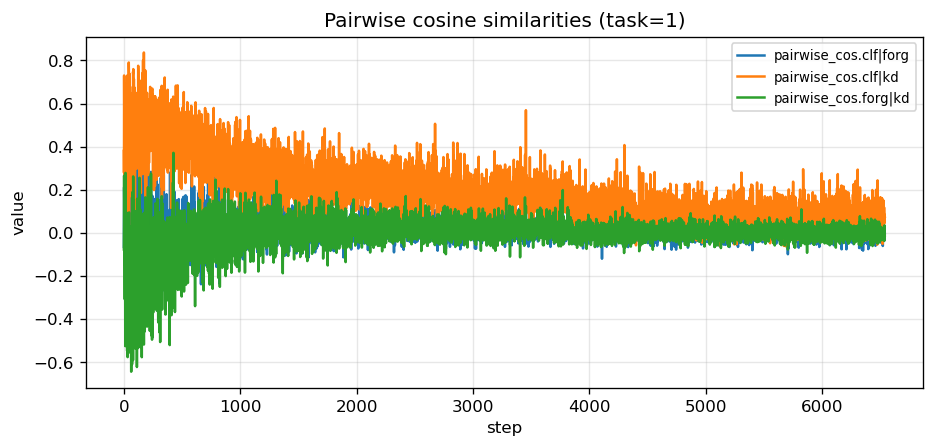

In [33]:
if len(cos_pairs):
    cols = [f"pairwise_cos.{p}" for p in cos_pairs]
    plot_timeseries(df, cols, x_col="step", title="Pairwise cosine similarities", by=("task" if "task" in df.columns else None))
else:
    print("No pairwise_cos.* columns found.")


## Example: grad norm over steps

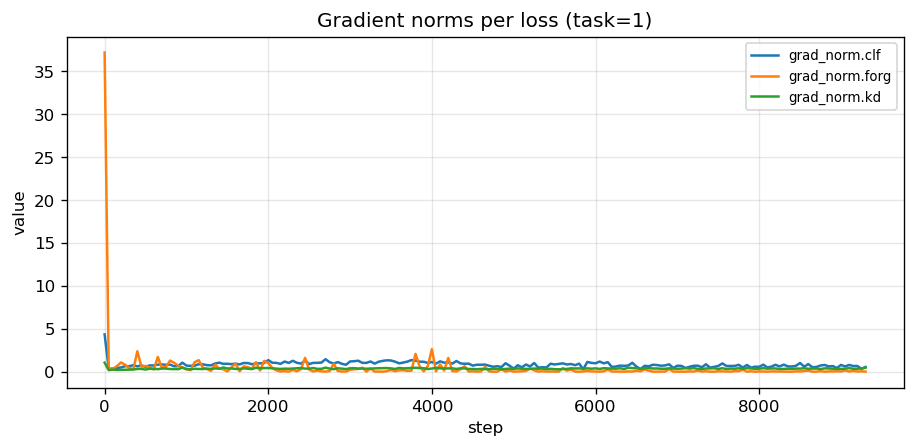

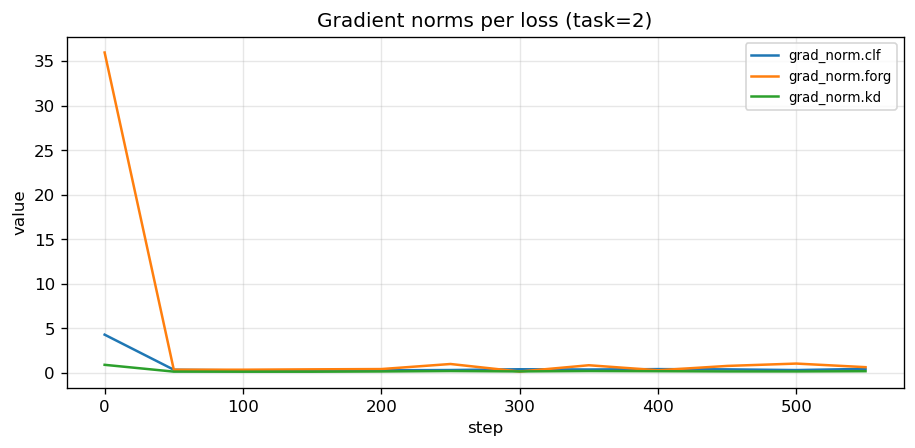

In [11]:
if len(loss_names):
    cols = [f"grad_norm.{n}" for n in loss_names]
    plot_timeseries(df, cols, x_col="step", title="Gradient norms per loss", by=("task" if "task" in df.columns else None))
else:
    print("No grad_norm.* columns found.")


## Example: heatmap of mean cosine per task

In [ ]:
if summary_cos is not None:
    plot_heatmap(summary_cos, title=f"Mean cosine similarities grouped by {group_key}")
else:
    print("No cosine columns found.")


## Example: histogram of a cosine pair

In [ ]:
if len(cos_pairs):
    col = f"pairwise_cos.{cos_pairs[0]}"
    plot_hist(df, col, title=f"Distribution: {col}")
else:
    print("No pairwise_cos.* columns found.")


## Tips

- Filter a specific run:
```python
df_run = df[df["_path"].str.contains("icarl_mu.jsonl")].copy()
```

- Focus a task range:
```python
df_t = df[(df["task"] >= 2) & (df["task"] <= 5)].copy()
```
